# Attention Mechanism in Graphs

The attention mechanism, a pivotal concept in deep learning, has found a powerful application in the realm of graph neural networks (GNNs), leading to the development of Graph Attention Networks (GATs). Unlike traditional GNNs that might aggregate information from neighbors uniformly or based on pre-defined structures, attention mechanisms allow GNNs to dynamically weigh the importance of different neighboring nodes when updating a node's representation.

<p style='text-align:center;'><img src='https://www.researchgate.net/publication/351743683/figure/fig4/AS:1025724328710145@1621563145840/Graph-attention-mechanism.ppm'></p>
<caption> source : https://www.researchgate.net/publication/351743683/figure/fig4/AS:1025724328710145@1621563145840/Graph-attention-mechanism.ppm</caption>

A GNN processes graph-structured data where we have nodes (entities) connected by edges (relationships). The key idea is that each node's representation should be influenced by its neighbors in the graph.

## Why use Attention?
The attention mechanism proides the following benefits by:

+ **Dynamic Weighting**: Allowing the model to learn a set of "attention coefficients" that determine how much each neighbor contributes to the central node's updated representation.
+ **Feature-Dependent Importance**: These weights are typically calculated based on the features of the central node and its neighbors, making the aggregation process data-driven and adaptive.
+ **Improved Expressiveness**: By selectively focusing on important neighbors, GATs can capture more complex relationships and dependencies within the graph.
+ **Handling Varying Neighborhood Sizes**: It naturally handles nodes with different numbers of neighbors, as the attention mechanism normalizes the contributions within each node's neighborhood.

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, softmax
from sklearn.manifold import TSNE

In [3]:
def load_dataset(verbose=False):
    print('..Loading Dataset..')
    dataset = Planetoid(root = 'data/Cora', name='Cora')
    data = dataset[0]
    if verbose:
        print(f'Dataset                   : {dataset}')
        print(f'Number of graphs          : {len(dataset)}')
        print(f'Number of nodes           : {data.x.shape[0]}')
        print(f'Number of edges           : {data.edge_index.shape[1]}')
        print(f'Number of node features   : {data.x.shape[1]}')
        print(f'Number of classes         : {dataset.num_classes}')
        print(f'Number of training nodes  : {data.train_mask.sum()}')
        print(f'Number of validation nodes: {data.val_mask.sum()}')
        print(f'Number of test nodes      : {data.test_mask.sum()}')
        print()
    return data, dataset.num_classes

## Adding attention

How it generally works (e.g., in Graph Attention Networks - GATs):

<p style='text-align:center;'><img src='https://www.researchgate.net/publication/378886448/figure/fig4/AS:11431281230565850@1710999942263/The-calculation-process-of-multi-head-graph-attention-mechanism.jpg'></p>

+ **Feature Transformation**: Each node's features are projected into a higher-dimensional space using a learnable weight matrix.

+ **Attention Score Computation**: For each node-neighbor pair, an attention score is computed—typically by concatenating their transformed features, passing them through a small neural network, and applying a non-linear activation (e.g., LeakyReLU).

+ **Normalization**: These scores are normalized via softmax across a node's neighbors to form a probability distribution, highlighting the relative importance of each neighbor.

+ **Aggregation**: A node’s updated representation is a weighted sum of its neighbors’ transformed features, using the attention weights.

+ **Multi-Head Attention**: Multiple attention heads run in parallel to capture varied relational patterns. Their outputs are combined (e.g., concatenated or averaged) for richer representations.

In [4]:
def train(model, data, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    model.train()
    train_l = []
    val_accuracy = []
    print("..Training Model..\n")
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = pred.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
        model.train()
        train_l.append(loss.item())
        val_accuracy.append(val_acc.item())

        if epoch%5 == 0:
            print(f'Epoch {epoch+1}/{epochs},  Loss : {loss:.4f},  Val acc : {val_acc:.4f}')

    print('\n..Training Complete..\n')
    
    return model, train_l, val_accuracy

In [5]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        embed = model(data.x, data.edge_index).argmax(dim=1)
        test_acc = (embed[data.test_mask] == data.y[test_mask]).float().mean()
        print(f'\nAccuracy on test set : {test_acc:.4f}\n')

In [6]:
def visualize_results(t_l, v_l):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(t_l)
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    ax[1].plot(t_l)
    ax[1].set_title('Validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

In [7]:
def visualize_embed(model, data, num_classes):
    model.eval()
    with torch.no_grad():
        embed = model(data.x, data.edge_index)
        tsne = TSNE(n_components=2)
        embed_2d = tsne.fit_transform(embed.cpu().numpy())
        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set3(np.linspace(0,1,num_classes))

        for i in range(num_classes):
            mask = data.y.cpu().numpy() == i
            plt.scatter(embed_2d[mask, 0], embed_2d[mask, 1], c = [colors[i]], label=f'Class {i}', alpha=  0.85)
        plt.title('Node Embeddings plotted using Dimensionality reduction (t-sne)')
        plt.legend()
        plt.grid(True, alpha = 0.3)
        plt.show()

<hr>

## Dataset: Cora

+ A citation network of scientific papers
+ Nodes: 2,708 research papers
+ Edges: Citation relationships (5,429 edges)
+ Features: 1,433-dimensional bag-of-words vectors
+ Task: Classify papers into 7 research areas

In [8]:
data, num_classes = load_dataset()

..Loading Dataset..


Processing...
Done!


In [9]:
data, num_classes = load_dataset(True)
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

..Loading Dataset..
Dataset                   : Cora()
Number of graphs          : 1
Number of nodes           : 2708
Number of edges           : 10556
Number of node features   : 1433
Number of classes         : 7
Number of training nodes  : 140
Number of validation nodes: 500
Number of test nodes      : 1000



<hr>

## Multi Head Attention in Graphs

Similar to Transformers, GATs often employ multi-head attention. This involves running the attention mechanism multiple times with different, independent sets of learnable parameters ($W$ and $a$). The outputs from each "attention head" can then be concatenated or averaged to produce the final node representation. This helps stabilize the learning process and allows the model to capture different types of relationships or aspects of the neighborhood.

<p style='text-align:center'>
    <img src='https://www.interdb.jp/dl/part04/ch15/fig-15-07.png'>
</p>

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, dropout=0.2):
        super(MultiHeadAttention, self).__init__()
        assert hidden_dim % num_heads == 0
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim//num_heads

        self.Wk = nn.Linear(hidden_dim, hidden_dim)
        self.Wq = nn.Linear(hidden_dim, hidden_dim)
        self.Wv = nn.Linear(hidden_dim, hidden_dim)
        self.Wo = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.D = self.head_dim ** -0.5
    
    def forward(self, x):
        x = x.unsqueeze(0)
        N = x.size(0)
        num_nodes = x.size(1)
        k = self.Wk(x).view(N, num_nodes, self.num_heads, self.head_dim)
        q = self.Wq(x).view(N, num_nodes, self.num_heads, self.head_dim)
        v = self.Wv(x).view(N, num_nodes, self.num_heads, self.head_dim)

        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        
        score = torch.matmul(q, k.transpose(-2, -1)) * self.D
        score = F.softmax(score, dim=-1)
        score = self.dropout(score)

        out = torch.matmul(score, v).transpose(1, 2).contiguous().view(N, num_nodes, self.hidden_dim)
        out = self.Wo(out)
        out = out.squeeze(0)
        return out

In [11]:
class GCN_SelfAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers, dropout = 0.2):
        super(GCN_SelfAttention, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        self.att_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)

        self.conv_layers.append(GCNConv(in_dim, hidden_dim))
        self.att_layers.append(MultiHeadAttention(hidden_dim, num_heads=8))
        self.bn_layers.append(nn.BatchNorm1d(hidden_dim))
        for _ in range(num_layers-2):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.att_layers.append(MultiHeadAttention(hidden_dim, num_heads=8))
            self.bn_layers.append(nn.BatchNorm1d(hidden_dim))

        self.conv_layers.append(GCNConv(hidden_dim, out_dim))

    def forward(self, x, edge_index):
        res = None
        for i in range(self.num_layers-1):
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            x = F.relu(x)
            x = self.att_layers[i](x)
            if res is not None:
                x = x + res
            res = x

        x = F.relu(x)
        x = self.conv_layers[-1](x, edge_index)
        return x                        

Number of parameter : 416391

Model Architecture:
GCN_SelfAttention(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 128)
    (1-2): 2 x GCNConv(128, 128)
    (3): GCNConv(128, 7)
  )
  (att_layers): ModuleList(
    (0-2): 3 x MultiHeadAttention(
      (Wk): Linear(in_features=128, out_features=128, bias=True)
      (Wq): Linear(in_features=128, out_features=128, bias=True)
      (Wv): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (bn_layers): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

..Training Model..

Epoch 1/50,  Loss : 1.9973,  Val acc : 0.1400
Epoch 6/50,  Loss : 2.8640,  Val acc : 0.1220
Epoch 11/50,  Loss : 1.8326,  Val acc : 0.2060
Epoch 16/50,  Loss : 0.7828,  Val acc : 0.6120
Epoch 21/50,  Loss : 0.1784,  Val acc : 0.6360
Epoch 

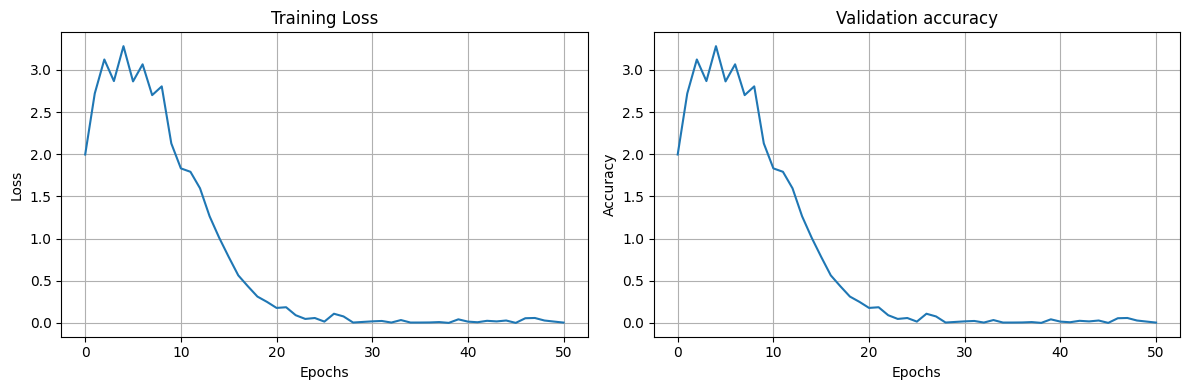

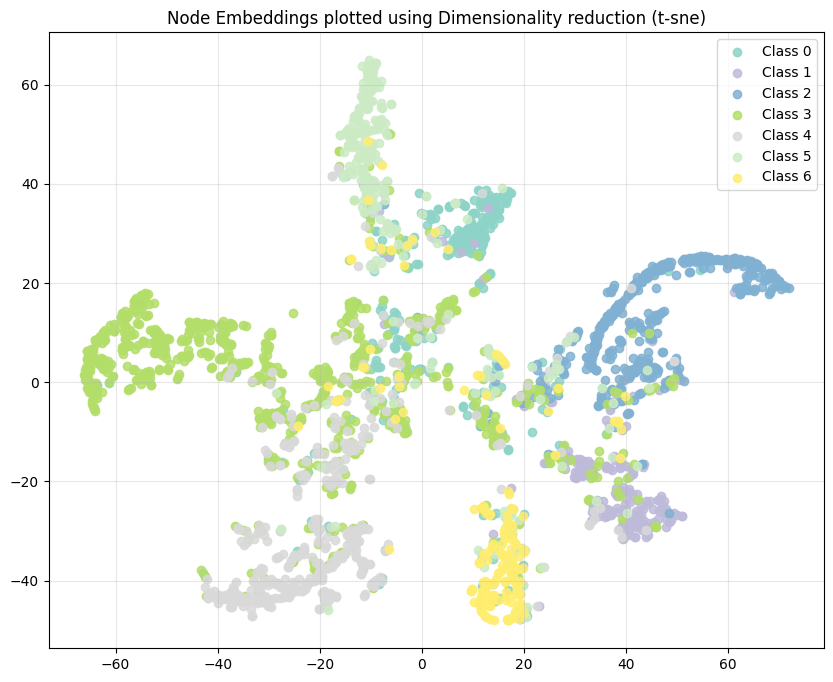

In [12]:
Graph_nn = GCN_SelfAttention(
    in_dim = data.x.shape[1], # 1433 features for CORA
    hidden_dim = 128,
    out_dim = num_classes,
    num_layers = 4
)
print(f"Number of parameter : {sum(p.numel() for p in Graph_nn.parameters())}\n")
print('Model Architecture:')
print(Graph_nn)
print()

Graph_nn, data = Graph_nn.to(device), data.to(device)

Graph_nn, train_loss, val_accuracy = train(Graph_nn, data, epochs = 50)

visualize_results(train_loss, val_accuracy)
visualize_embed(Graph_nn, data, num_classes)

<hr>

## Graph Attention Network
The core idea of a GAT layer is to compute a new feature representation for each node by aggregating the features of its neighbors, weighted by learned attention coefficients. This typically involves the following steps:

+ Linear Transformation
+ Unnormalized Attention Score Computation
+ Normalization with Softmax
+ Weighted Sum Aggregation

<p style='text-align:center'>
    <img src='https://www.researchgate.net/publication/340064449/figure/fig4/AS:941670958895110@1601523260369/The-details-of-the-soft-attention-mechanism-in-graph-convolution-layer-For-each-object.png' width=100%>
</p>

<caption>source : https://www.researchgate.net/figure/The-details-of-the-soft-attention-mechanism-in-graph-convolution-layer-For-each-object_fig4_340064449</caption>

The same functionality can be reached using the torch_geometric.nn.GATConv layer but it includes multihead attributes as well

In [13]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_feat ,out_feat, dropout=0.2, alpha = 0.2):
        super(GraphAttentionLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.dropout = dropout
        self.alpha = alpha
        self.W = nn.Linear(in_feat, out_feat)
        self.a = nn.Linear(2*out_feat, 1)
        self.leakyrelu = nn.LeakyReLU(alpha)

    
    def forward(self, x, edge_index):
        N = x.size(0)

        # Transforming all node features
        h = self.W(x)                                   # (N, out_feat)
        src_feat, dst_feat = h[edge_index[0]], h[edge_index[1]]   # (N, out_feat) : features of src and dst nodes

        # Attention score for each edge
        edge_feat  = torch.cat([src_feat, dst_feat], dim=1)  # (N, 2*out_feat)

        # Computing raw attention scores
        att_scores = self.a(edge_feat).squeeze()  # (N, 1) -> (N)
        att_scores = self.leakyrelu(att_scores)   # (N)

        # Noramlize the attention scores
        att_w = softmax(att_scores, edge_index[1], num_nodes=N)
        att_w= F.dropout(att_w, self.dropout, training = self.training)
        # edge_e tells how much destination node pay attentions to the source node

        
        # Aggregate neighbor features using attention weights
        out = torch.zeros_like(h)
        w_features = att_w.unsqueeze(1) * src_feat
        out.scatter_add_(0, edge_index[1].unsqueeze(1).expand(-1, h.size(1)), w_features)
            
        # Original shape of x i.e., (N, out_feat)
        return out

In [14]:
class GraphAttentionNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers, dropout = 0.2):
        super(GraphAttentionNetwork, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        self.att_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout = dropout

        self.conv_layers.append(GCNConv(in_dim, hidden_dim))
        self.att_layers.append(GraphAttentionLayer(hidden_dim, hidden_dim))
        self.bn_layers.append(nn.BatchNorm1d(hidden_dim))
        for _ in range(num_layers-2):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.att_layers.append(GraphAttentionLayer(hidden_dim, hidden_dim))
            self.bn_layers.append(nn.BatchNorm1d(hidden_dim))

        self.conv_layers.append(GCNConv(hidden_dim, out_dim))

    def forward(self, x, edge_index):
        res = None
        for i in range(self.num_layers-1):
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            x = self.att_layers[i](x, edge_index)
            if res is not None:
                x = x + res
            res = x
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(x)
        x = self.conv_layers[-1](x, edge_index)
        return x                        

Number of parameter : 268554

Model Architecture:
GraphAttentionNetwork(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 128)
    (1-2): 2 x GCNConv(128, 128)
    (3): GCNConv(128, 7)
  )
  (att_layers): ModuleList(
    (0-2): 3 x GraphAttentionLayer(
      (W): Linear(in_features=128, out_features=128, bias=True)
      (a): Linear(in_features=256, out_features=1, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (bn_layers): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

..Training Model..

Epoch 1/50,  Loss : 2.1360,  Val acc : 0.1800
Epoch 6/50,  Loss : 0.1098,  Val acc : 0.7500
Epoch 11/50,  Loss : 0.0513,  Val acc : 0.7320
Epoch 16/50,  Loss : 0.0056,  Val acc : 0.7360
Epoch 21/50,  Loss : 0.0117,  Val acc : 0.7320
Epoch 26/50,  Loss : 0.0118,  Val acc : 0.7200
Epoch 31/50,  Loss : 0.0719,  Val acc : 0.7400
Epoch 36/50,  Loss : 0.0315,  Val acc : 0.7280
Epoch 41/50,  Loss : 0.0603,  Val a

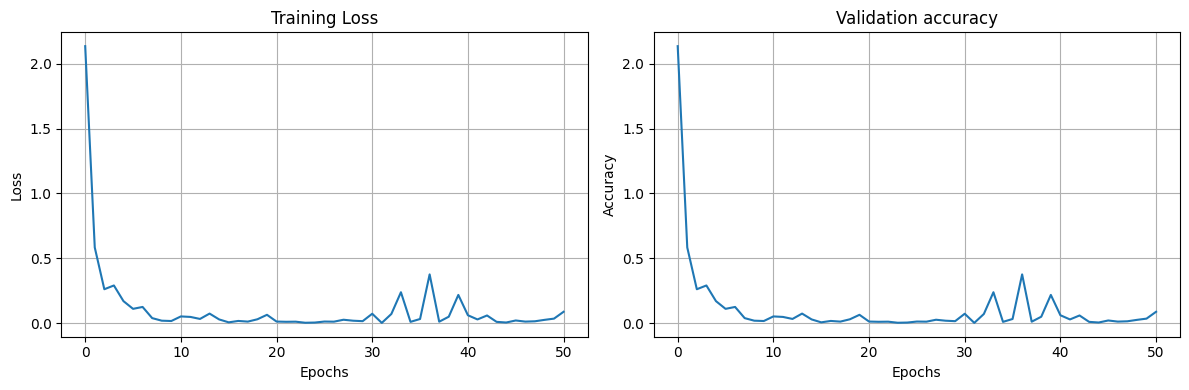

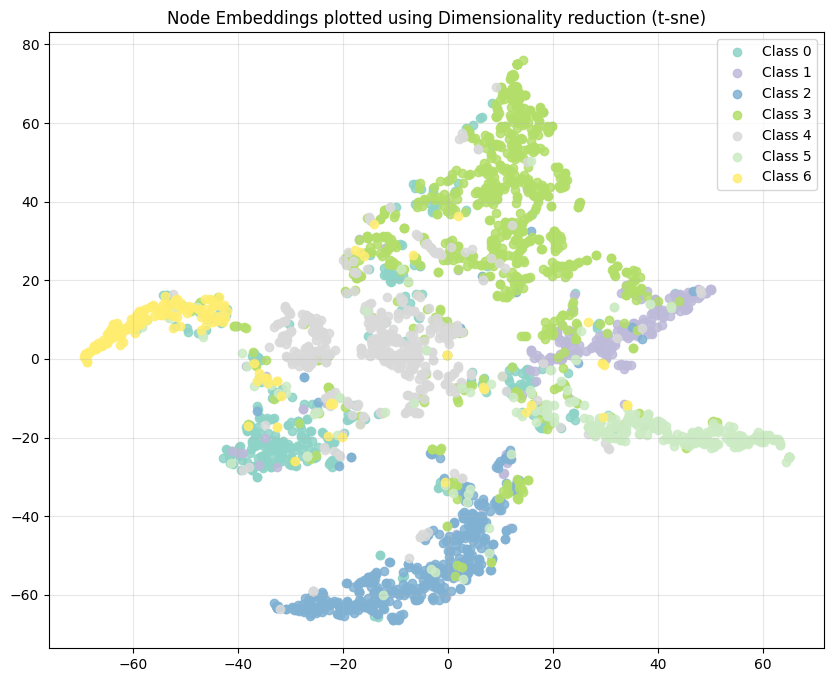

In [15]:
Graph_nn = GraphAttentionNetwork(
    in_dim = data.x.shape[1], # 1433 features for CORA
    hidden_dim = 128,
    out_dim = num_classes,
    num_layers = 4
)
print(f"Number of parameter : {sum(p.numel() for p in Graph_nn.parameters())}\n")
print('Model Architecture:')
print(Graph_nn)
print()

Graph_nn, data = Graph_nn.to(device), data.to(device)

Graph_nn, train_loss, val_accuracy = train(Graph_nn, data, epochs = 50)

visualize_results(train_loss, val_accuracy)
visualize_embed(Graph_nn, data, num_classes)

### References 

+ Graph Attention Networks (GAT) – Introduced attention mechanisms in GNNs to learn the importance of neighboring nodes.
<a href='https://arxiv.org/abs/1710.10903'> Veličković et al., 2018 – arXiv:1710.10903</a>

+ Attention Is All You Need – Origin of the attention mechanism used in Transformers, later adapted to graphs.
<a href='https://arxiv.org/abs/1706.03762'>Vaswani et al., 2017 – arXiv:1706.03762</a>

+ Semi-Supervised Classification with GCNs – Baseline GCN model that GAT builds upon by adding attention.
<a href='https://arxiv.org/abs/1609.02907'>Kipf & Welling, 2016 – arXiv:1609.02907</a>

+ The Graph Neural Network Model – Early general framework for neural networks on graphs.
<a href='https://ieeexplore.ieee.org/document/4700287'>Scarselli et al., 2008 – IEEE</a>